# 1. 데이터셋 준비하기

stanford_dogs로 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test) , ds_info = tfds.load(
    "stanford_dogs",
    split=["train","test"],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


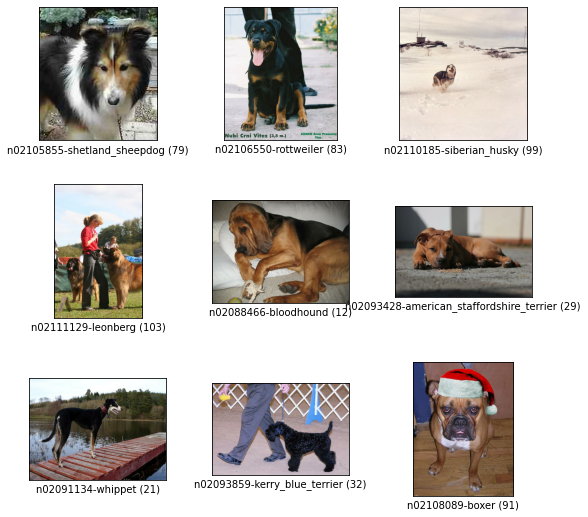

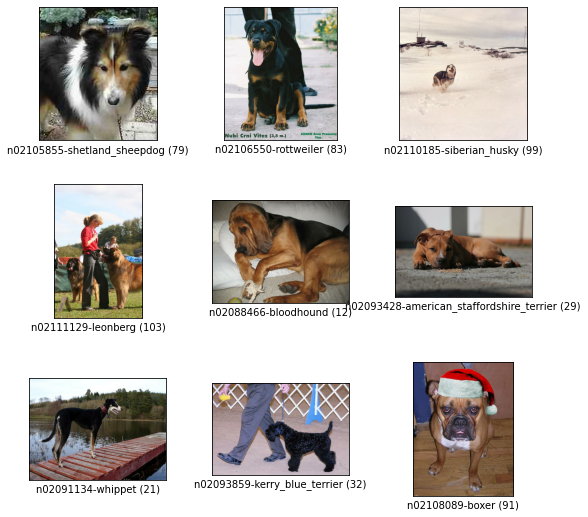

In [4]:
tfds.show_examples(ds_train, ds_info)

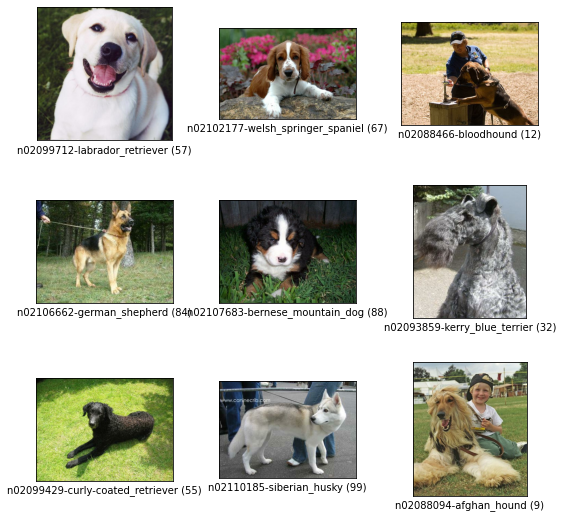

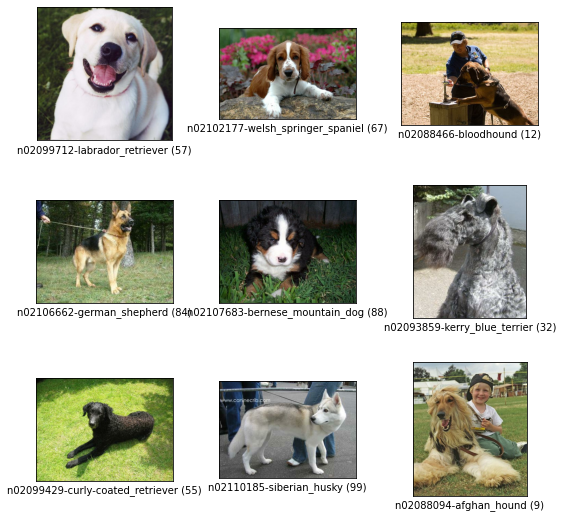

In [5]:
tfds.show_examples(ds_test, ds_info)

# 2. 물체의 위치정보를 파악하는 방법 - BBox

Bbox에 대한 정보를 얻기위해 ds_info.features를 통해 먼저 데이터셋의 특징들을 살펴보자.

In [6]:
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

ds_info.features["objects"] 에 'bbox' 정보가 있다
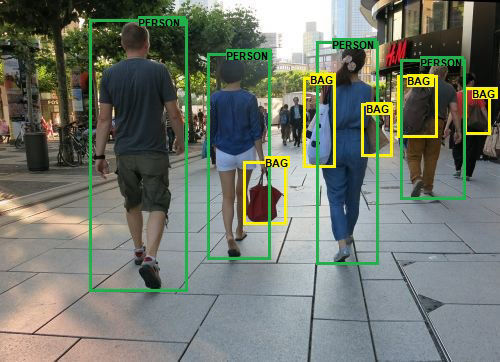

그렇다면 이 bbox를 표시하는 법을 알면 어디 부분을 인식중인지 확인할수 있다
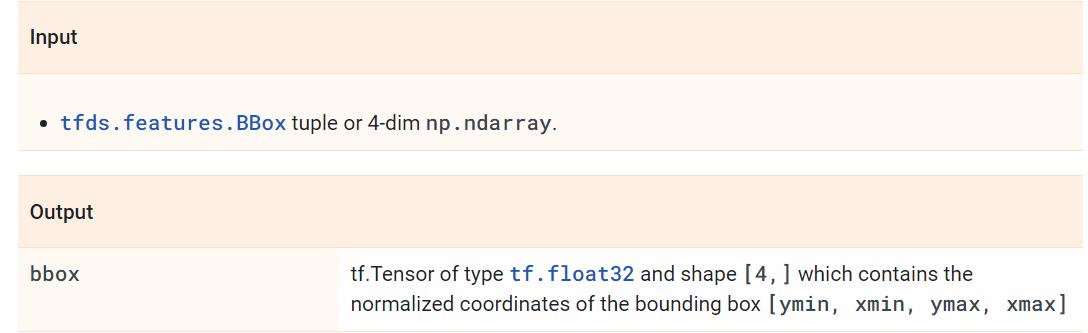

minmax방식으로 표현한다

# 3. CAM을 위한 모델 작성
ResNet50기반

In [7]:
num_classes = ds_info.features['label'].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top = False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg', #GAP
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs = base_model.input, outputs = preds)




94781440/94765736 [==============================] - 1s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# 4. CAM 모델 학습

데이터 전처리 - 정규화 메소드

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input["image"], [224,224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16): #정규화 , resize, batch, prefetch 
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2,
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds



In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)


(16, 224, 224, 3)
(16,)


모델을 이제 컴파일하고 전처리한 데이터를 학습시킨다

In [11]:
cam_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
    
)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data = ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    
    
)

Epoch 1/2
750/750 [==============================] - 146s 194ms/step - loss: 0.6515 - accuracy: 0.8258 - val_loss: 1.3342 - val_accuracy: 0.6154
Epoch 2/2
750/750 [==============================] - 151s 201ms/step - loss: 0.1755 - accuracy: 0.9740 - val_loss: 1.0237 - val_accuracy: 0.7059


In [14]:
import os
cam_model_path = os.getenv("HOME") + '/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("CAM 모델 저장 완료")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


CAM 모델 저장 완료


# 5 CAM - 학습된 모델로 생성하기

In [16]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [19]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


    

46


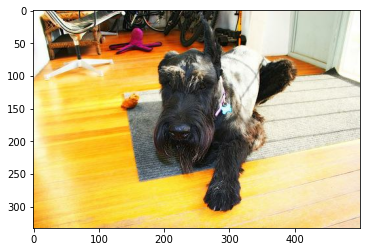

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

CAM생성을 위한 데이터가 준비되었으므로 모델을 불러오자

In [23]:
cam_model_path = os.getenv("HOME")+'/aiffel/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)


CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다.

이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 <b>CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화</b>해야 할 것입니다.

In [32]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output,model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))
    conv_outputs = conv_outputs[0,:,:,:]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])
    for i , w in enumerate(class_weights[:,class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:,:,i]
        
    cam_image /= np.max(cam_image) # 이미지 255로 나눈것처럼 정규화
    cam_image = cam_image.numpy() # numpy로 변환
    cam_image = cv2.resize(cam_image, (width, height)) # width, height로 이미지와 같은 크기로 변경
    return cam_image
    
        
        
    

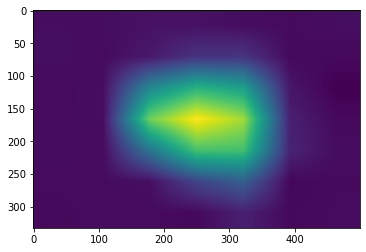

In [33]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

cam과 원본이미지를 합치자

In [39]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

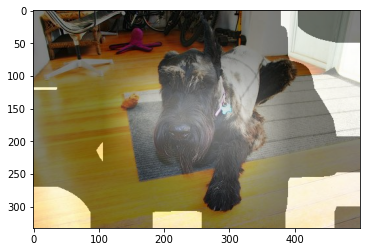

In [40]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()


In [35]:
a = np.stack([cam_image]*3, axis=-1).astype(np.uint8)

# 6. Grad_CAM

108


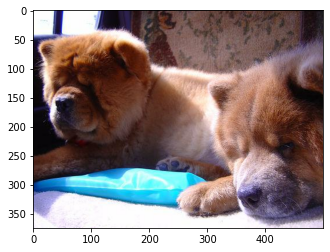

In [51]:
# 새 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

 Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.

In [52]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
     # Gradient를 얻기 위해 tape를 사용합니다.
        
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx] # 원하는 class의 예측값 .. ?? 왜 근데 loss로 놓는지??
        output = conv_output[0] # 원하는 layer의 예측값
        grad_val = tape.gradient(loss, conv_output)[0] #예측값에 따른 layer의 gradient
        
    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다. #0, 1차원에 대해서 np.mean = GAP한것과 동일
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image
    

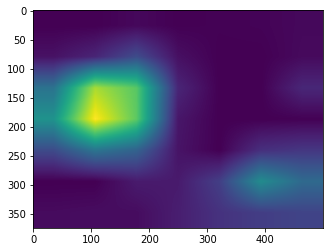

In [53]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

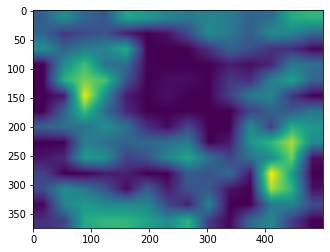

In [54]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

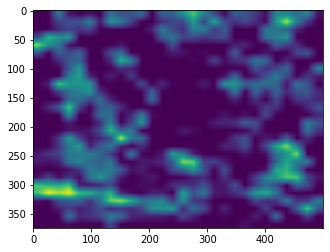

In [55]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# 7.Detection with CAM - CAM에서 물체 위치 찾기

100


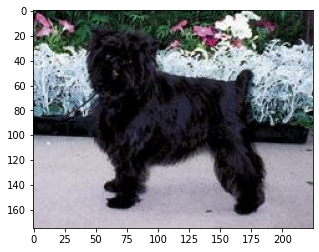

In [56]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

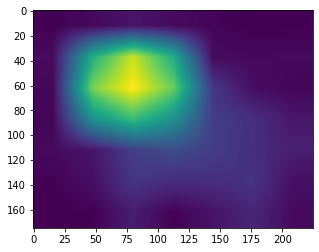

In [57]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앱니다. 

그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 

이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다. boxPoints()로 이를 꼭지점으로 바꾸어 줍니다. 

마지막에는 int 자료형으로 변환해 줍니다.

In [58]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image * 255).astype(np.uint8)
    
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect) #np.int64
    return rect
    
    
    

In [59]:
rect = get_bbox(cam_image)
rect

array([[ 18, 174],
       [ 18,   0],
       [224,   0],
       [224, 174]])

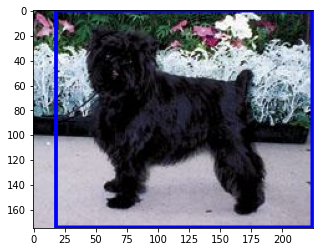

In [60]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image,[rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

CAM_이미지로 만든 bbox를 원본과 합했다

# Intersection Over Union

In [62]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


기존 rect는 cv2에서 받은 좌표로 x,y지만 tf쪽에선 이미지 좌표가 y, x로 구성 

CAM에서 얻은 rect (bbox) 좌표들중 각 축별로 min max값을 구해 pred_bbox로 y_min, x_min , y_max, x_max로 바꾼다 

In [63]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.08, 0.9942857142857143, 0.9955555555555555]

In [64]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

출력값을 보면 기존 ds의 item feature값이 다음처럼 정규화되어 표현된것을 볼 수 있다. 이 두 minmax좌표점들을 통해 각각의

영역을 구하고, 각 영역에서 겹치는 부분 / 각 영역 모두 합한 부분 해서 IoU를 구한다

In [70]:
def get_iou(boxA, boxB): 
    #맨처음 이 네 좌표는  두 영역의 y_min 값중 max, 즉 서로의 영역에서 겹치는 부분의 좌표를 구하는것이다.
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min) #교집합 영역 위에서 구한 좌표를 사용해서 구한다.
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]) # A영역
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]) # B영역
    iou = interArea / float(boxAArea + boxBArea - interArea) #A합 B합 - A교B = A합B 인것은 잘 알것이다.

    return iou

In [71]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.644570935528774

# 회고
CAM을 만들고 visualize하는 부분이 가장 어려웠던 것 같다. 나머지 부분들은 좌표를 중심으로 IoU구해서 출력하는 것이였어서 익숙했다.



---

generate_cam은 모델구조를 고정해야 한다는 특징 -> (1)model.layers[-3]는 GAP이전의 conv레이어 , (2)model.layers[-1]에 weight activation


    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0]

(3) class_idx에 클래스 출력값 index

CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다.


이미지 정규화해서 

이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다.

---

generate_grad_cam은 모델구조에 상관없이 단순히 어떤 레이어든 그레디언트 관찰을 원하는 레이어를 대상으로 만든다.- activation layer 이름사용

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.  1차원에 대해서 np.mean = GAP한것과 동일

    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    for k, w in enumerate(weights):
    
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        
        grad_cam_image += w * output[:, :, k]
        
---

다음처럼 cam과 grad_cam은 Class Activation Map을 얻는 과정에서 큰 차이가 있다는걸 볼수있다.

---

bbox - IoU로 계산해 정확성 판단.


tfds dataset의 ds 데이터셋들에서 볼수 있는 objects - bbox 특징에서 좌표값들을 보면 0.~로 표현되어있다.

이와 똑같이 맞추기 위해 generate_cam, _grad_cam 과정에서 마지막에 정규화하여 데이터셋 이미지 크기로 resize하는 것을 볼 수 있었다.

그렇게 pred_rect의 bbox좌표와 기존 데이터셋의 rect좌표값들을 통해 IoU를 구하게 된다